<a href="https://colab.research.google.com/github/JunyingLLL/Quest-for-the-Heir-to-Sergio-Busquets/blob/main/Midfielder_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Midfielder Segments

1st phase progression (P1): build up duties, back-to-goal reception, retention, circulation, volume passing

2nd phase progression (P2): linking defence to attack, progressing into final 3rd, vertical carrying/passing power

3rd phase progression (P3): chance creation, half-space & zone 14 explorer, goal threat

Deep defending (D1): transition defence, shielding, holding, positioning, not getting dribbled past

Middle defending (D2): ball-winning, tackling, running intensity, space-covering, duel-winning

High defending (D3): high pressing, disrupting opposition build up, counter-press initiating

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import scipy.stats as stats
from math import pi

In [ ]:
sns.set(style="darkgrid")

# 2. Clean datasets

### a. Standard Stats

In [ ]:
# Load dataset
std_stats_df = pd.read_html('https://fbref.com/en/comps/Big5/2022-2023/stats/players/2022-2023-Big-5-European-Leagues-Stats', header = 1)[0]
std_stats_df.head()

,Rk,Player,Nation,Pos,Squad,Comp,Age,Born,MP,Starts,...,Ast.1,G+A.1,G-PK.1,G+A-PK,xG.1,xAG.1,xG+xAG,npxG.1,npxG+xAG.1,Matches
0,1,Brenden Aaronson,us USA,"MF,FW",Leeds United,eng Premier League,21,2000,36,28,...,0.11,0.15,0.04,0.15,0.15,0.16,0.31,0.15,0.31,Matches
1,2,Paxten Aaronson,us USA,"MF,DF",Eint Frankfurt,de Bundesliga,18,2003,7,0,...,0.00,0.00,0.00,0.00,0.09,0.03,0.11,0.09,0.11,Matches
2,3,James Abankwah,ie IRL,DF,Udinese,it Serie A,18,2004,2,1,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Matches
3,4,George Abbott,eng ENG,MF,Tottenham,eng Premier League,16,2005,1,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Matches
4,5,Yunis Abdelhamid,ma MAR,DF,Reims,fr Ligue 1,34,1987,37,37,...,0.05,0.08,0.03,0.08,0.06,0.03,0.09,0.06,0.09,Matches


In [ ]:
def clean_table(df, col_list):
    '''
    Extract relevant features and clean data

    Args:
    -------
    df: dataframe to clean
    col_list: list of features to extract

    Returns:
    ---------
    df: cleaned dataframe
    '''

    # Extract rows with midfielders
    df = df[df["Pos"].str.contains("MF")]

    # Extract relevant features
    df = df[col_list]

    # Remove null values
    df = df.dropna()

    # Remove players that played < 1000 mins
    df = df[df["90s"].astype(float) >= 11.1]

    # Reset index
    df = df.reset_index(drop = True)

    # Return dataframe
    return df

In [ ]:
# List of columns
std_stats_df.columns

Index(['Rk', 'Player', 'Nation', 'Pos', 'Squad', 'Comp', 'Age', 'Born', 'MP',
       'Starts', 'Min', '90s', 'Gls', 'Ast', 'G+A', 'G-PK', 'PK', 'PKatt',
       'CrdY', 'CrdR', 'xG', 'npxG', 'xAG', 'npxG+xAG', 'PrgC', 'PrgP', 'PrgR',
       'Gls.1', 'Ast.1', 'G+A.1', 'G-PK.1', 'G+A-PK', 'xG.1', 'xAG.1',
       'xG+xAG', 'npxG.1', 'npxG+xAG.1', 'Matches'],
      dtype='object')

In [ ]:
# Columns to extract
std_stats_columns = ["Player", "Pos", "Squad", "Age", "Min", "90s", "PrgC", "PrgP", "PrgR", "Gls.1", "Ast.1", "G+A.1", "G-PK.1", "G+A-PK", "xG.1", "xAG.1", "xG+xAG", "npxG.1", "npxG+xAG.1"]

# Clean dataset
std_stats_df = clean_table(std_stats_df, std_stats_columns)

# Check number of players
std_stats_df.shape

(673, 19)

In [ ]:
# Rename columns
colname_dict = {"Gls.1": "Goals", "Ast.1": "Ast", "G+A.1": "Goals+Ast",
                "G-PK.1": "npGoals", "G+A-PK": "npGoals+Ast", "xG.1": "xG",
                "xAG.1": "xAG", "npxG.1": "npxG", "npxG+xAG.1": "npxG+xAG"}
std_stats_df = std_stats_df.rename(columns = colname_dict)

In [ ]:
# Function to convert statistic to per 90
def per_90(df, col_name):
    df[col_name] = round(df[col_name].astype(float) / df["90s"].astype(float), 2)
    return df

In [ ]:
# Convert statistics to per 90
per90_cols = ["PrgC", "PrgP", "PrgR"]
for col in per90_cols:
    std_stats_df = per_90(std_stats_df, col)

In [ ]:
# Normalize statistics
scaler = StandardScaler()
std_stats_df[std_stats_df.columns[6:]] = scaler.fit_transform(std_stats_df.iloc[:, 6:])
std_stats_df.head()

,Player,Pos,Squad,Age,Min,90s,PrgC,PrgP,PrgR,Goals,Ast,Goals+Ast,npGoals,npGoals+Ast,xG,xAG,xG+xAG,npxG,npxG+xAG
0,Brenden Aaronson,"MF,FW",Leeds United,21,2372,26.4,-0.305789,-0.612589,0.495830,-0.781967,-0.089304,-0.584107,-0.742185,-0.540368,0.004943,0.407483,0.201885,0.141877,0.305302
1,Himad Abdelli,"MF,FW",Angers,22,2137,23.7,0.376068,1.054489,0.139426,-0.500354,-0.373249,-0.487486,-0.435278,-0.438813,-0.782917,-0.078536,-0.556506,-0.747719,-0.513296
2,Salis Abdul Samed,MF,Lens,22,2894,32.2,-0.813024,0.384442,-0.994899,-0.852370,-0.846491,-1.018904,-0.818912,-0.997364,-1.045536,-0.929068,-1.139884,-1.044250,-1.142988
3,Laurent Abergel,MF,Lorient,29,2342,26.0,-1.245421,0.588136,-1.279336,-1.063580,-0.751842,-1.115525,-1.049092,-1.098918,-1.133076,-0.929068,-1.198222,-1.143094,-1.205957
4,Zakaria Aboukhlal,"FW,MF",Toulouse,22,2473,27.5,1.365592,-0.955653,1.976278,1.470935,0.573234,1.348321,1.713068,1.490727,2.368521,-0.078536,1.543655,2.810664,1.753591


### b. Passing Stats

In [ ]:
# Load dataset
passing_df = pd.read_html('https://fbref.com/en/comps/Big5/2022-2023/passing/players/2022-2023-Big-5-European-Leagues-Stats', header = 1)[0]
passing_df.head()

,Rk,Player,Nation,Pos,Squad,Comp,Age,Born,90s,Cmp,...,Ast,xAG,xA,A-xAG,KP,1/3,PPA,CrsPA,PrgP,Matches
0,1,Brenden Aaronson,us USA,"MF,FW",Leeds United,eng Premier League,21,2000,26.4,592,...,3,4.2,2.6,-1.2,46,47,16,4,86,Matches
1,2,Paxten Aaronson,us USA,"MF,DF",Eint Frankfurt,de Bundesliga,18,2003,1.9,51,...,0,0.0,0.1,0.0,1,3,0,0,6,Matches
2,3,James Abankwah,ie IRL,DF,Udinese,it Serie A,18,2004,0.7,23,...,0,0.0,0.0,0.0,0,0,0,0,0,Matches
3,4,George Abbott,eng ENG,MF,Tottenham,eng Premier League,16,2005,0.0,1,...,0,0.0,0.0,0.0,0,0,0,0,0,Matches
4,5,Yunis Abdelhamid,ma MAR,DF,Reims,fr Ligue 1,34,1987,37.0,1679,...,2,1.0,0.9,+1.0,13,155,5,0,215,Matches


In [ ]:
# List of columns
passing_df.columns

Index(['Rk', 'Player', 'Nation', 'Pos', 'Squad', 'Comp', 'Age', 'Born', '90s',
       'Cmp', 'Att', 'Cmp%', 'TotDist', 'PrgDist', 'Cmp.1', 'Att.1', 'Cmp%.1',
       'Cmp.2', 'Att.2', 'Cmp%.2', 'Cmp.3', 'Att.3', 'Cmp%.3', 'Ast', 'xAG',
       'xA', 'A-xAG', 'KP', '1/3', 'PPA', 'CrsPA', 'PrgP', 'Matches'],
      dtype='object')

In [ ]:
# Columns to extract
passing_columns = ["Player", "Pos", "Squad", "Age", "90s", "Cmp", "Cmp%", "TotDist", "PrgDist", "Cmp.1", "Cmp%.1", "Cmp.2", "Cmp%.2", "Cmp.3", "Cmp%.3", "KP", "1/3", "PPA"]

# Clean dataset
passing_df = clean_table(passing_df, passing_columns)

# Check number of players
passing_df.shape

(673, 18)

In [ ]:
# Rename columns
colname_dict = {"Cmp": "TotalCmp", "Cmp%": "TotalCmp%",
                "Cmp.1": "ShortCmp", "Cmp%.1": "ShortCmp%",
                "Cmp.2": "MedCmp", "Cmp%.2": "MedCmp%",
                "Cmp.3": "LongCmp", "Cmp%.3": "LongCmp%",
                "KP": "KeyPass", "1/3": "FinalThird",
                "PPA": "PassesIntoPenArea"}
passing_df = passing_df.rename(columns = colname_dict)

In [ ]:
# Convert statistics to per 90
per90_cols = ["TotalCmp", "TotDist", "PrgDist", "ShortCmp", "MedCmp", "LongCmp", "KeyPass", "FinalThird", "PassesIntoPenArea"]
for col in per90_cols:
    passing_df = per_90(passing_df, col)

In [ ]:
# Normalize statistics
scaler = StandardScaler()
passing_df[passing_df.columns[5:]] = scaler.fit_transform(passing_df.iloc[:, 5:])
passing_df.head()

,Player,Pos,Squad,Age,90s,TotalCmp,TotalCmp%,TotDist,PrgDist,ShortCmp,ShortCmp%,MedCmp,MedCmp%,LongCmp,LongCmp%,KeyPass,FinalThird,PassesIntoPenArea
0,Brenden Aaronson,"MF,FW",Leeds United,21,26.4,-0.915652,-0.453415,-1.155133,-1.031302,-0.651578,-0.719607,-1.186144,-0.536935,-1.120242,-1.623797,0.861590,-0.833300,-0.627566
1,Himad Abdelli,"MF,FW",Angers,22,23.7,0.663188,0.700440,0.766805,0.329959,0.346291,0.197376,0.740327,0.473123,1.004938,1.105589,0.512999,1.004952,0.232157
2,Salis Abdul Samed,MF,Lens,22,32.2,1.575829,1.867557,1.241889,0.591993,1.609338,1.334436,1.716320,1.641382,-0.153791,1.623929,-1.055663,1.228740,-0.767928
3,Laurent Abergel,MF,Lorient,29,26.0,1.123896,1.390100,1.109021,1.473317,0.835262,1.279417,1.355904,1.191116,0.559662,0.878815,-1.039818,1.170129,-0.960927
4,Zakaria Aboukhlal,"FW,MF",Toulouse,22,27.5,-1.023150,-0.479940,-1.206200,-1.152905,-0.582601,-0.426173,-1.174980,-0.646459,-1.378299,-1.388924,-0.627846,-1.200950,-0.294204


### c. Goal-Creating Actions

In [ ]:
# Load dataset
gca_df = pd.read_html('https://fbref.com/en/comps/Big5/2022-2023/gca/players/2022-2023-Big-5-European-Leagues-Stats', header = 1)[0]
gca_df.head()

,Rk,Player,Nation,Pos,Squad,Comp,Age,Born,90s,SCA,...,Def,GCA,GCA90,PassLive.1,PassDead.1,TO.1,Sh.1,Fld.1,Def.1,Matches
0,1,Brenden Aaronson,us USA,"MF,FW",Leeds United,eng Premier League,21,2000,26.4,95,...,1,7,0.27,3,1,0,1,1,1,Matches
1,2,Paxten Aaronson,us USA,"MF,DF",Eint Frankfurt,de Bundesliga,18,2003,1.9,8,...,0,2,1.04,1,0,0,1,0,0,Matches
2,3,James Abankwah,ie IRL,DF,Udinese,it Serie A,18,2004,0.7,0,...,0,0,0.00,0,0,0,0,0,0,Matches
3,4,George Abbott,eng ENG,MF,Tottenham,eng Premier League,16,2005,0.0,0,...,0,0,0.00,0,0,0,0,0,0,Matches
4,5,Yunis Abdelhamid,ma MAR,DF,Reims,fr Ligue 1,34,1987,37.0,43,...,2,7,0.19,4,0,2,1,0,0,Matches


In [ ]:
# List of columns
gca_df.columns

Index(['Rk', 'Player', 'Nation', 'Pos', 'Squad', 'Comp', 'Age', 'Born', '90s',
       'SCA', 'SCA90', 'PassLive', 'PassDead', 'TO', 'Sh', 'Fld', 'Def', 'GCA',
       'GCA90', 'PassLive.1', 'PassDead.1', 'TO.1', 'Sh.1', 'Fld.1', 'Def.1',
       'Matches'],
      dtype='object')

In [ ]:
# Columns to extract
gca_columns = ["Player", "Pos", "Squad", "Age", "90s", "SCA90", "GCA90"]

# Clean dataset
gca_df = clean_table(gca_df, gca_columns)

# Check number of players
gca_df.shape

(673, 7)

In [ ]:
# Rename columns
colname_dict = {"SCA90": "SCA", "GCA90": "GCA"}
gca_df = gca_df.rename(columns = colname_dict)

In [ ]:
# Normalize statistics
scaler = StandardScaler()
gca_df[gca_df.columns[5:]] = scaler.fit_transform(gca_df.iloc[:, 5:])
gca_df.head()

,Player,Pos,Squad,Age,90s,SCA,GCA
0,Brenden Aaronson,"MF,FW",Leeds United,21,26.4,0.755627,-0.112240
1,Himad Abdelli,"MF,FW",Angers,22,23.7,0.135131,-0.848169
2,Salis Abdul Samed,MF,Lens,22,32.2,-1.087876,-1.373832
3,Laurent Abergel,MF,Lorient,29,26.0,-1.339672,-1.321266
4,Zakaria Aboukhlal,"FW,MF",Toulouse,22,27.5,0.135131,-0.007108


### d. Defensive Actions

In [ ]:
# Load dataset
def_df = pd.read_html('https://fbref.com/en/comps/Big5/2022-2023/defense/players/2022-2023-Big-5-European-Leagues-Stats', header = 1)[0]
def_df.head()

,Rk,Player,Nation,Pos,Squad,Comp,Age,Born,90s,Tkl,...,Tkl%,Lost,Blocks,Sh,Pass,Int,Tkl+Int,Clr,Err,Matches
0,1,Brenden Aaronson,us USA,"MF,FW",Leeds United,eng Premier League,21,2000,26.4,45,...,32.6,31,43,3,40,5,50,6,1,Matches
1,2,Paxten Aaronson,us USA,"MF,DF",Eint Frankfurt,de Bundesliga,18,2003,1.9,6,...,66.7,1,2,1,1,0,6,2,0,Matches
2,3,James Abankwah,ie IRL,DF,Udinese,it Serie A,18,2004,0.7,1,...,NaN,0,4,2,2,0,1,5,0,Matches
3,4,George Abbott,eng ENG,MF,Tottenham,eng Premier League,16,2005,0.0,0,...,NaN,0,0,0,0,1,1,0,0,Matches
4,5,Yunis Abdelhamid,ma MAR,DF,Reims,fr Ligue 1,34,1987,37.0,82,...,75.0,13,65,27,38,64,146,116,1,Matches


In [ ]:
# List of columns
def_df.columns

Index(['Rk', 'Player', 'Nation', 'Pos', 'Squad', 'Comp', 'Age', 'Born', '90s',
       'Tkl', 'TklW', 'Def 3rd', 'Mid 3rd', 'Att 3rd', 'Tkl.1', 'Att', 'Tkl%',
       'Lost', 'Blocks', 'Sh', 'Pass', 'Int', 'Tkl+Int', 'Clr', 'Err',
       'Matches'],
      dtype='object')

In [ ]:
# Columns to extract
def_columns = ["Player", "Pos", "Squad", "Age", "90s", "Tkl", "TklW", "Def 3rd", "Mid 3rd", "Att 3rd", "Tkl.1", "Tkl%", "Lost", "Sh", "Pass", "Int", "Tkl+Int", "Clr"]

# Clean dataset
def_df = clean_table(def_df, def_columns)

# Check number of players
def_df.shape

(673, 18)

In [ ]:
# Rename columns
colname_dict = {"Tkl": "Tackles", "TklW": "TacklesWon",
                "Def 3rd": "Def3rdTkls", "Mid 3rd": "Mid3rdTkls",
                "Att 3rd": "Att3rdTkls", "Tkl.1": "DribTackled",
                "Tkl%": "DribTackled%", "Lost": "DribTackleFailed",
                "Sh": "ShotsBlocked", "Pass": "PassesBlocked"}
def_df = def_df.rename(columns = colname_dict)

In [ ]:
# Normalize statistics
scaler = StandardScaler()
def_df[def_df.columns[5:]] = scaler.fit_transform(def_df.iloc[:, 5:])
def_df.head()

,Player,Pos,Squad,Age,90s,Tackles,TacklesWon,Def3rdTkls,Mid3rdTkls,Att3rdTkls,DribTackled,DribTackled%,DribTackleFailed,ShotsBlocked,PassesBlocked,Int,Tkl+Int,Clr
0,Brenden Aaronson,"MF,FW",Leeds United,21,26.4,0.265341,-0.374721,0.003875,0.438171,0.279374,-0.219087,-0.759469,0.655437,-0.350852,2.059471,-1.074893,-0.249534,-0.889574
1,Himad Abdelli,"MF,FW",Angers,22,23.7,1.151680,1.186328,0.562700,1.399036,1.050995,1.274975,0.342591,1.063570,-0.815662,0.913997,0.731455,1.060763,-0.396650
2,Salis Abdul Samed,MF,Lens,22,32.2,0.311990,0.249698,0.190150,0.534258,-0.235041,1.088218,1.106794,0.002426,1.043577,0.913997,1.359750,0.748788,0.205812
3,Laurent Abergel,MF,Lorient,29,26.0,2.457866,2.279063,4.008789,1.206863,-0.749455,2.022006,0.028866,2.451219,0.811172,1.955337,1.202676,2.121480,0.917813
4,Zakaria Aboukhlal,"FW,MF",Toulouse,22,27.5,-0.294453,0.015541,-0.275538,-0.810953,1.308202,-0.312465,-0.880133,0.655437,-0.815662,-0.335612,0.260234,-0.093546,0.041504


### e. Possession

In [ ]:
# Load dataset
pos_df = pd.read_html('https://fbref.com/en/comps/Big5/2022-2023/possession/players/2022-2023-Big-5-European-Leagues-Stats', header = 1)[0]
pos_df.head()

,Rk,Player,Nation,Pos,Squad,Comp,Age,Born,90s,Touches,...,TotDist,PrgDist,PrgC,1/3,CPA,Mis,Dis,Rec,PrgR,Matches
0,1,Brenden Aaronson,us USA,"MF,FW",Leeds United,eng Premier League,21,2000,26.4,1143,...,3646,1532,43,34,13,71,82,767,151,Matches
1,2,Paxten Aaronson,us USA,"MF,DF",Eint Frankfurt,de Bundesliga,18,2003,1.9,99,...,314,143,8,2,2,5,2,65,15,Matches
2,3,James Abankwah,ie IRL,DF,Udinese,it Serie A,18,2004,0.7,39,...,48,19,0,0,0,1,1,21,0,Matches
3,4,George Abbott,eng ENG,MF,Tottenham,eng Premier League,16,2005,0.0,2,...,0,0,0,0,0,0,0,1,0,Matches
4,5,Yunis Abdelhamid,ma MAR,DF,Reims,fr Ligue 1,34,1987,37.0,2459,...,10871,6123,40,21,3,27,23,1499,10,Matches


In [ ]:
# List of columns
pos_df.columns

Index(['Rk', 'Player', 'Nation', 'Pos', 'Squad', 'Comp', 'Age', 'Born', '90s',
       'Touches', 'Def Pen', 'Def 3rd', 'Mid 3rd', 'Att 3rd', 'Att Pen',
       'Live', 'Att', 'Succ', 'Succ%', 'Tkld', 'Tkld%', 'Carries', 'TotDist',
       'PrgDist', 'PrgC', '1/3', 'CPA', 'Mis', 'Dis', 'Rec', 'PrgR',
       'Matches'],
      dtype='object')

In [ ]:
# Columns to extract
pos_columns = ["Player", "Pos", "Squad", "Age", "90s", "Touches", "Def Pen", "Def 3rd", "Mid 3rd", "Att 3rd", "Carries", "Mis", "Dis", "Rec"]

# Clean dataset
pos_df = clean_table(pos_df, pos_columns)

# Check number of players
pos_df.shape

(673, 14)

In [ ]:
# Rename columns
colname_dict = {"Def Pen": "DefPenTouches", "Def 3rd": "Def3rdTouches",
                "Mid 3rd": "Mid3rdTouches", "Att 3rd": "Att3rdTouches",
                "Mis": "Miscontrols", "Dis": "Dispossessed", "Rec": "Passes Received"}
pos_df = pos_df.rename(columns = colname_dict)

In [ ]:
# Normalize statistics
scaler = StandardScaler()
pos_df[pos_df.columns[5:]] = scaler.fit_transform(pos_df.iloc[:, 5:])
pos_df.head()

,Player,Pos,Squad,Age,90s,Touches,DefPenTouches,Def3rdTouches,Mid3rdTouches,Att3rdTouches,Carries,Miscontrols,Dispossessed,Passes Received
0,Brenden Aaronson,"MF,FW",Leeds United,21,26.4,-0.120631,-0.828807,-0.764322,-0.390015,1.000749,-0.157580,1.785873,4.091099,-0.123476
1,Himad Abdelli,"MF,FW",Angers,22,23.7,0.591463,-0.419658,0.017994,0.878852,0.239472,1.200724,-0.022727,-0.251108,0.645604
2,Salis Abdul Samed,MF,Lens,22,32.2,1.943103,0.749339,1.097719,2.659505,-0.122790,3.014524,0.132295,0.589319,2.289221
3,Laurent Abergel,MF,Lorient,29,26.0,1.093555,1.041589,2.242098,1.348242,-1.115075,1.746228,-0.384448,-0.321144,1.136888
4,Zakaria Aboukhlal,"FW,MF",Toulouse,22,27.5,-0.082449,-0.244308,-0.505705,-0.508119,1.090002,0.428836,2.405965,0.869461,0.072009


### f. Join datasets

In [ ]:
# Merge all datasets
common_cols = ["Player", "Pos", "Squad", "Age", "90s"]
midfielders_df = pd.merge(std_stats_df, passing_df, on = common_cols, how = "inner")
midfielders_df = pd.merge(midfielders_df, gca_df, on = common_cols, how = "inner")
midfielders_df = pd.merge(midfielders_df, def_df, on = common_cols, how = "inner")
midfielders_df = pd.merge(midfielders_df, pos_df, on = common_cols, how = "inner")
midfielders_df.shape

(673, 56)

In [ ]:
# Check merged dataset
midfielders_df.head()

,Player,Pos,Squad,Age,Min,90s,PrgC,PrgP,PrgR,Goals,...,Clr,Touches,DefPenTouches,Def3rdTouches,Mid3rdTouches,Att3rdTouches,Carries,Miscontrols,Dispossessed,Passes Received
0,Brenden Aaronson,"MF,FW",Leeds United,21,2372,26.4,-0.305789,-0.612589,0.495830,-0.781967,...,-0.889574,-0.120631,-0.828807,-0.764322,-0.390015,1.000749,-0.157580,1.785873,4.091099,-0.123476
1,Himad Abdelli,"MF,FW",Angers,22,2137,23.7,0.376068,1.054489,0.139426,-0.500354,...,-0.396650,0.591463,-0.419658,0.017994,0.878852,0.239472,1.200724,-0.022727,-0.251108,0.645604
2,Salis Abdul Samed,MF,Lens,22,2894,32.2,-0.813024,0.384442,-0.994899,-0.852370,...,0.205812,1.943103,0.749339,1.097719,2.659505,-0.122790,3.014524,0.132295,0.589319,2.289221
3,Laurent Abergel,MF,Lorient,29,2342,26.0,-1.245421,0.588136,-1.279336,-1.063580,...,0.917813,1.093555,1.041589,2.242098,1.348242,-1.115075,1.746228,-0.384448,-0.321144,1.136888
4,Zakaria Aboukhlal,"FW,MF",Toulouse,22,2473,27.5,1.365592,-0.955653,1.976278,1.470935,...,0.041504,-0.082449,-0.244308,-0.505705,-0.508119,1.090002,0.428836,2.405965,0.869461,0.072009


# 3. Barcelona Midfielders Analysis

In [ ]:
# Extract Barca midfielder statistics
barca_mid_df = midfielders_df.loc[midfielders_df["Player"].isin(["Gavi", "Pedri", "Sergio Busquets", "Frenkie de Jong", "İlkay Gündoğan"])]
barca_mid_df

,Player,Pos,Squad,Age,Min,90s,PrgC,PrgP,PrgR,Goals,...,Clr,Touches,DefPenTouches,Def3rdTouches,Mid3rdTouches,Att3rdTouches,Carries,Miscontrols,Dispossessed,Passes Received
94,Sergio Busquets,MF,Barcelona,34,2339,26.0,-0.829655,2.877018,-1.042876,-1.063580,...,0.753505,1.843830,0.632440,0.987806,2.432381,0.050466,1.459838,-0.901191,-0.811393,1.893107
228,Gavi,"MF,FW",Barcelona,17,2531,28.1,-0.214321,0.196829,0.399875,-0.570758,...,-0.013265,0.578099,-0.390433,-0.557429,0.524539,1.126753,0.704316,1.010759,0.659354,0.817939
263,İlkay Gündoğan,MF,Manchester City,31,2353,26.1,0.026824,1.129535,0.163415,1.118919,...,-0.506189,1.145101,-0.273533,0.056786,1.063580,1.221257,0.895242,-0.436122,0.239141,1.569013
309,Frenkie de Jong,MF,Barcelona,25,2534,28.2,1.049610,2.941343,-0.456865,-0.570758,...,-0.013265,2.519650,0.135616,1.013668,2.813950,1.279009,2.872693,-0.642819,-0.111037,3.140610
486,Pedri,MF,Barcelona,19,1976,22.0,0.874988,2.121205,0.077741,0.837306,...,-0.780035,0.851100,-0.799582,-0.473378,0.999985,1.011249,1.249819,-0.229425,0.519283,1.334946


In [ ]:
# List of features
barca_mid_df.columns

Index(['Player', 'Pos', 'Squad', 'Age', 'Min', '90s', 'PrgC', 'PrgP', 'PrgR',
       'Goals', 'Ast', 'Goals+Ast', 'npGoals', 'npGoals+Ast', 'xG', 'xAG',
       'xG+xAG', 'npxG', 'npxG+xAG', 'TotalCmp', 'TotalCmp%', 'TotDist',
       'PrgDist', 'ShortCmp', 'ShortCmp%', 'MedCmp', 'MedCmp%', 'LongCmp',
       'LongCmp%', 'KeyPass', 'FinalThird', 'PassesIntoPenArea', 'SCA', 'GCA',
       'Tackles', 'TacklesWon', 'Def3rdTkls', 'Mid3rdTkls', 'Att3rdTkls',
       'DribTackled', 'DribTackled%', 'DribTackleFailed', 'ShotsBlocked',
       'PassesBlocked', 'Int', 'Tkl+Int', 'Clr', 'Touches', 'DefPenTouches',
       'Def3rdTouches', 'Mid3rdTouches', 'Att3rdTouches', 'Carries',
       'Miscontrols', 'Dispossessed', 'Passes Received'],
      dtype='object')

### P1: build up duties, back-to-goal reception, retention, circulation, volume passing

In [ ]:
# Extract features used for p1
p1_df = barca_mid_df[["Player", "TotalCmp", "TotalCmp%", "Miscontrols", "DefPenTouches", "Def3rdTouches"]]
p1_df

,Player,TotalCmp,TotalCmp%,Miscontrols,DefPenTouches,Def3rdTouches
94,Sergio Busquets,2.288098,1.416625,-0.901191,0.632440,0.987806
228,Gavi,0.114726,0.978956,1.010759,-0.390433,-0.557429
263,İlkay Gündoğan,1.294285,1.244210,-0.436122,-0.273533,0.056786
309,Frenkie de Jong,2.862155,1.628828,-0.642819,0.135616,1.013668
486,Pedri,1.602886,1.138109,-0.229425,-0.799582,-0.473378


In [ ]:
# Create copy of dataframe
p1_df = p1_df.copy()

# Compute negatives of miscontrols
p1_df.loc[:, "Miscontrols"] *= -1

# Inverse Norm
p1_df[p1_df.columns[1:]] = stats.norm.cdf(p1_df.iloc[:, 1:])

In [ ]:
# Compute mean of all statistics
p1_df["P1_Mean"] = round(p1_df.mean(axis = 1, numeric_only = True), 2)
p1_df

,Player,TotalCmp,TotalCmp%,Miscontrols,DefPenTouches,Def3rdTouches,P1_Mean
94,Sergio Busquets,0.988934,0.921704,0.816257,0.736450,0.838376,0.86
228,Gavi,0.545669,0.836199,0.156066,0.348108,0.288617,0.43
263,İlkay Gündoğan,0.902216,0.893289,0.668626,0.392222,0.522642,0.68
309,Frenkie de Jong,0.997896,0.948325,0.739829,0.553938,0.844629,0.82
486,Pedri,0.945520,0.872462,0.590731,0.211977,0.317972,0.59


### P2: linking defence to attack, progressing into final 3rd, vertical carrying/passing power

In [ ]:
# Extract features used for p2
p2_df = barca_mid_df[["Player", "PrgC", "PrgP", "FinalThird", "Dispossessed", "Mid3rdTouches"]]
p2_df

,Player,PrgC,PrgP,FinalThird,Dispossessed,Mid3rdTouches
94,Sergio Busquets,-0.829655,2.877018,2.933785,-0.811393,2.432381
228,Gavi,-0.214321,0.196829,0.077834,0.659354,0.524539
263,İlkay Gündoğan,0.026824,1.129535,1.138159,0.239141,1.063580
309,Frenkie de Jong,1.049610,2.941343,2.944442,-0.111037,2.813950
486,Pedri,0.874988,2.121205,2.118560,0.519283,0.999985


In [ ]:
# Create copy of dataframe
p2_df = p2_df.copy()

# Compute negatives of dispossessed
p2_df.loc[:, "Dispossessed"] *= -1

# Inverse Norm
p2_df[p2_df.columns[1:]] = stats.norm.cdf(p2_df.iloc[:, 1:])

In [ ]:
# Compute mean of all statistics
p2_df["P2_Mean"] = round(p2_df.mean(axis = 1, numeric_only = True), 2)
p2_df

,Player,PrgC,PrgP,FinalThird,Dispossessed,Mid3rdTouches,P2_Mean
94,Sergio Busquets,0.203367,0.997993,0.998326,0.791430,0.992500,0.80
228,Gavi,0.415149,0.578019,0.531020,0.254834,0.700048,0.50
263,İlkay Gündoğan,0.510700,0.870664,0.872473,0.405498,0.856240,0.70
309,Frenkie de Jong,0.853051,0.998366,0.998382,0.544207,0.997553,0.88
486,Pedri,0.809210,0.983048,0.982936,0.301782,0.841341,0.78


### P3: chance creation, half-space & zone 14 explorer, goal threat

In [ ]:
# Extract features used for p3
p3_df = barca_mid_df[["Player", "npxG+xAG", "KeyPass", "SCA", "GCA", "PassesIntoPenArea", "Att3rdTouches"]]
p3_df

,Player,npxG+xAG,KeyPass,SCA,GCA,PassesIntoPenArea,Att3rdTouches
94,Sergio Busquets,-0.828142,-0.374325,0.081175,-0.322506,0.530427,0.050466
228,Gavi,-0.135482,0.243633,-0.179613,-0.217373,0.793608,1.126753
263,İlkay Gündoğan,0.746086,0.354548,0.611744,1.885279,0.653245,1.221257
309,Frenkie de Jong,-0.135482,0.639759,1.034401,0.518555,1.969146,1.279009
486,Pedri,1.186869,1.130956,1.079365,1.096785,0.688336,1.011249


In [ ]:
# Create copy of dataframe
p3_df = p3_df.copy()

# Inverse Norm
p3_df[p3_df.columns[1:]] = stats.norm.cdf(p3_df.iloc[:, 1:])

In [ ]:
# Compute mean of all statistics
p3_df["P3_Mean"] = round(p3_df.mean(axis = 1, numeric_only = True), 2)
p3_df

,Player,npxG+xAG,KeyPass,SCA,GCA,PassesIntoPenArea,Att3rdTouches,P3_Mean
94,Sergio Busquets,0.203795,0.354081,0.532349,0.373535,0.702092,0.520124,0.45
228,Gavi,0.446115,0.596242,0.428728,0.413959,0.786288,0.870077,0.59
263,İlkay Gündoğan,0.772192,0.638536,0.729646,0.970304,0.743201,0.889006,0.79
309,Frenkie de Jong,0.446115,0.738835,0.849526,0.697965,0.975532,0.899553,0.77
486,Pedri,0.882360,0.870963,0.859787,0.863632,0.754379,0.844051,0.85


### D1: transition defence, shielding, holding, positioning, not getting dribbled past

In [ ]:
# Extract features used for d1
d1_df = barca_mid_df[["Player", "DribTackled", "DribTackled%", "PassesBlocked"]]
d1_df

,Player,DribTackled,DribTackled%,PassesBlocked
94,Sergio Busquets,1.088218,1.195280,0.601594
228,Gavi,0.341187,-0.308992,0.705729
263,İlkay Gündoğan,-0.499223,-0.542275,-0.543880
309,Frenkie de Jong,-0.032329,-0.043532,-1.064550
486,Pedri,-0.405844,-1.057106,0.705729


In [ ]:
# Create copy of dataframe
d1_df = d1_df.copy()

# Inverse Norm
d1_df[d1_df.columns[1:]] = stats.norm.cdf(d1_df.iloc[:, 1:])

In [ ]:
# Compute mean of all statistics
d1_df["D1_Mean"] = round(d1_df.mean(axis = 1, numeric_only = True), 2)
d1_df

,Player,DribTackled,DribTackled%,PassesBlocked,D1_Mean
94,Sergio Busquets,0.861750,0.884011,0.726278,0.82
228,Gavi,0.633518,0.378664,0.759822,0.59
263,İlkay Gündoğan,0.308811,0.293815,0.293262,0.30
309,Frenkie de Jong,0.487105,0.482639,0.143540,0.37
486,Pedri,0.342429,0.145232,0.759822,0.42


### D2: ball-winning, tackling, running intensity, space-covering, duel-winning

In [ ]:
# Extract features used for d2
d2_df = barca_mid_df[["Player", "Tackles", "TacklesWon", "Int"]]
d2_df

,Player,Tackles,TacklesWon,Int
94,Sergio Busquets,0.871784,0.249698,0.652918
228,Gavi,0.358639,0.639961,-0.053914
263,İlkay Gündoğan,-0.434402,-0.374721,0.103160
309,Frenkie de Jong,0.311990,0.249698,1.281213
486,Pedri,-0.014556,-0.062512,-0.446598


In [ ]:
# Create copy of dataframe
d2_df = d2_df.copy()

# Inverse Norm
d2_df[d2_df.columns[1:]] = stats.norm.cdf(d2_df.iloc[:, 1:])

In [ ]:
# Compute mean of all statistics
d2_df["D2_Mean"] = round(d2_df.mean(axis = 1, numeric_only = True), 2)
d2_df

,Player,Tackles,TacklesWon,Int,D2_Mean
94,Sergio Busquets,0.808337,0.598590,0.743095,0.72
228,Gavi,0.640068,0.738901,0.478502,0.62
263,İlkay Gündoğan,0.331998,0.353934,0.541082,0.41
309,Frenkie de Jong,0.622476,0.598590,0.899941,0.71
486,Pedri,0.494193,0.475078,0.327583,0.43


### D3: high pressing, disrupting opposition build up, counter-press initiating

In [ ]:
# Extract features used for d2
d3_df = barca_mid_df[["Player", "Att3rdTkls"]]
d3_df

,Player,Att3rdTkls
94,Sergio Busquets,0.536581
228,Gavi,1.050995
263,İlkay Gündoğan,1.050995
309,Frenkie de Jong,0.793788
486,Pedri,0.279374


In [ ]:
# Create copy of dataframe
d3_df = d3_df.copy()

# Inverse Norm
d3_df[d3_df.columns[1:]] = stats.norm.cdf(d3_df.iloc[:, 1:])

In [ ]:
# Compute mean of all statistics
d3_df["D3_Mean"] = round(d3_df.mean(axis = 1, numeric_only = True), 2)
d3_df

,Player,Att3rdTkls,D3_Mean
94,Sergio Busquets,0.704221,0.70
228,Gavi,0.853370,0.85
263,İlkay Gündoğan,0.853370,0.85
309,Frenkie de Jong,0.786341,0.79
486,Pedri,0.610021,0.61


### Barca Midfielder Rankings

In [ ]:
# Concatenate Barca midfielders stats across all categories
category_means = [p1_df["Player"], p1_df["P1_Mean"], p2_df["P2_Mean"], p3_df["P3_Mean"], d1_df["D1_Mean"], d2_df["D2_Mean"], d3_df["D3_Mean"]]
barca_mid_rankings = pd.concat(category_means, axis = 1)
barca_mid_rankings

,Player,P1_Mean,P2_Mean,P3_Mean,D1_Mean,D2_Mean,D3_Mean
94,Sergio Busquets,0.86,0.80,0.45,0.82,0.72,0.70
228,Gavi,0.43,0.50,0.59,0.59,0.62,0.85
263,İlkay Gündoğan,0.68,0.70,0.79,0.30,0.41,0.85
309,Frenkie de Jong,0.82,0.88,0.77,0.37,0.71,0.79
486,Pedri,0.59,0.78,0.85,0.42,0.43,0.61


# 4. Principal Component Analysis

In [ ]:
midfielders_df.columns

Index(['Player', 'Pos', 'Squad', 'Age', 'Min', '90s', 'PrgC', 'PrgP', 'PrgR',
       'Goals', 'Ast', 'Goals+Ast', 'npGoals', 'npGoals+Ast', 'xG', 'xAG',
       'xG+xAG', 'npxG', 'npxG+xAG', 'TotalCmp', 'TotalCmp%', 'TotDist',
       'PrgDist', 'ShortCmp', 'ShortCmp%', 'MedCmp', 'MedCmp%', 'LongCmp',
       'LongCmp%', 'KeyPass', 'FinalThird', 'PassesIntoPenArea', 'SCA', 'GCA',
       'Tackles', 'TacklesWon', 'Def3rdTkls', 'Mid3rdTkls', 'Att3rdTkls',
       'DribTackled', 'DribTackled%', 'DribTackleFailed', 'ShotsBlocked',
       'PassesBlocked', 'Int', 'Tkl+Int', 'Clr', 'Touches', 'DefPenTouches',
       'Def3rdTouches', 'Mid3rdTouches', 'Att3rdTouches', 'Carries',
       'Miscontrols', 'Dispossessed', 'Passes Received'],
      dtype='object')

In [ ]:
pca_cols = ['PrgP', 'PrgR',
       'TotalCmp', 'TotalCmp%', 'TotDist',
       'PrgDist', 'ShortCmp', 'ShortCmp%', 'MedCmp', 'MedCmp%', 'LongCmp',
       'LongCmp%', 'KeyPass', 'FinalThird', 'PassesIntoPenArea',
       'Tackles', 'TacklesWon', 'Def3rdTkls', 'Mid3rdTkls',
       'DribTackled', 'DribTackled%', 'DribTackleFailed', 'ShotsBlocked',
       'PassesBlocked', 'Int', 'Tkl+Int', 'Clr', 'Touches', 'DefPenTouches',
       'Def3rdTouches', 'Mid3rdTouches',
       'Miscontrols', 'Dispossessed', 'Passes Received']

In [ ]:
# Extract numerical statistics of all midfielders
# pca_input = midfielders_df.iloc[:, 6:]
pca_input = midfielders_df[pca_cols]

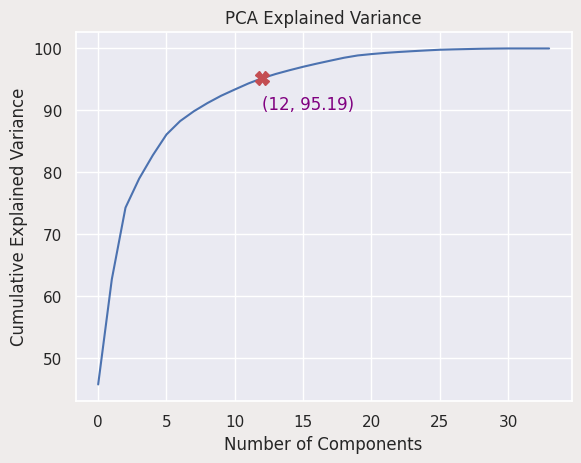

In [ ]:
# Find optimal number of components
pca = PCA(n_components = 34)
pca.fit(pca_input)
var = np.cumsum(np.round(pca.explained_variance_ratio_, decimals = 4) * 100)

# Line plot of cumulative explained variance
fig = plt.figure(facecolor='#efeceb')
plt.plot(var)
plt.plot(12, var[12], "rX", ms = 10)
plt.annotate("(12, 95.19)", xy = (12, var[12] - 5), color = "purple")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance")
plt.show()

In [ ]:
# Principal Component Analysis
pca = PCA(n_components = 12)
pca.fit(pca_input)
pca_df = pca.fit_transform(pca_input)
pca_df.shape

(673, 12)

# 5. Similar Player Analysis

In [ ]:
# Compute similarity between pairs of players
similarity_matrix = cosine_similarity(pca_df)
similarity_matrix.shape

(673, 673)

In [ ]:
def similar_players(player):
    '''
    Find top 15 similar players to input player

    Args:
    -----
    player: Name of input player

    Returns:
    --------
    List of top 15 similar players to input player
    '''

    # Index of input player
    index = midfielders_df.loc[(midfielders_df["Player"] == player)].index[0]

    # Sort similarity scores with other players
    similarity_ranking = np.argsort(similarity_matrix[index])

    # Extract index of top 15 similar players
    top_15_index = similarity_ranking[-16:-1][::-1]

    # Store top 15 similar players
    top_15_players = []

    for rank, idx in enumerate(top_15_index):

        # Extract and store player name
        player = midfielders_df.iloc[idx]["Player"]
        top_15_players.append(player)

        # Print rank and player name
        print("#{rank}: ".format(rank = rank + 1) + player)

    return top_15_players

In [ ]:
top_15 = similar_players("Sergio Busquets")

#1: Thomas Partey
#2: Corentin Tolisso
#3: Jordan Veretout
#4: Rodri
#5: Nemanja Matić
#6: William Carvalho
#7: Toni Kroos
#8: Marco Verratti
#9: Sofyan Amrabat
#10: Enzo Fernández
#11: Frenkie de Jong
#12: Joshua Kimmich
#13: Djibril Sow
#14: Fabián Ruiz Peña
#15: Thiago Mendes


In [ ]:
# Extract statistics of similar players
similar_df = midfielders_df.loc[midfielders_df["Player"].isin(["Sergio Busquets", "Thomas Partey", "Rodri", "William Carvalho", "Sofyan Amrabat", "Enzo Fernández", "Frenkie de Jong", "Joshua Kimmich", "Djibril Sow"])]
similar_df = similar_df.drop(538)
similar_df

,Player,Pos,Squad,Age,Min,90s,PrgC,PrgP,PrgR,Goals,...,Clr,Touches,DefPenTouches,Def3rdTouches,Mid3rdTouches,Att3rdTouches,Carries,Miscontrols,Dispossessed,Passes Received
27,Sofyan Amrabat,MF,Fiorentina,25,1998,22.2,-0.314104,1.890708,-1.094280,-1.063580,...,-0.232342,0.830100,0.135616,0.412384,1.460290,-0.563806,0.846147,-0.849516,-0.531251,0.979986
94,Sergio Busquets,MF,Barcelona,34,2339,26.0,-0.829655,2.877018,-1.042876,-1.063580,...,0.753505,1.843830,0.632440,0.987806,2.432381,0.050466,1.459838,-0.901191,-0.811393,1.893107
112,William Carvalho,MF,Betis,30,2438,27.1,-0.247582,1.654852,-0.806416,-0.289145,...,-0.013265,1.475374,-0.010509,0.444711,2.117436,0.034715,1.451656,-0.694494,0.239141,1.995994
199,Enzo Fernández,MF,Chelsea,21,1547,17.2,-0.596826,2.877018,-1.104561,-1.063580,...,-0.560958,0.782372,0.135616,0.755051,1.139288,-0.437801,0.963430,-0.591145,-0.741358,1.136888
309,Frenkie de Jong,MF,Barcelona,25,2534,28.2,1.049610,2.941343,-0.456865,-0.570758,...,-0.013265,2.519650,0.135616,1.013668,2.813950,1.279009,2.872693,-0.642819,-0.111037,3.140610
325,Joshua Kimmich,MF,Bayern Munich,27,2809,31.2,-0.538618,3.053911,-0.850966,0.062871,...,0.917813,3.563926,2.181361,2.481318,3.165235,2.339546,2.777229,-0.539471,0.169105,3.215203
482,Thomas Partey,MF,Arsenal,29,2483,27.6,-0.638402,2.126565,-1.029168,-0.289145,...,1.027352,2.025194,1.100039,1.188234,2.368786,0.538733,1.784413,-0.177750,-0.321144,2.158041
537,Rodri,MF,Manchester City,26,2911,32.3,0.292915,1.955033,-1.070292,-0.641161,...,1.136890,3.943837,2.298261,3.050275,4.146411,1.200256,3.437289,-0.797842,-0.321144,4.362392
592,Djibril Sow,MF,Eint Frankfurt,25,2646,29.4,-0.671664,1.033048,-1.125123,-0.077935,...,0.041504,1.152737,0.281741,0.819706,1.714669,-0.458802,0.971612,-0.642819,-0.531251,1.077728


### P1: build up duties, back-to-goal reception, retention, circulation, volume passing

In [ ]:
# Extract features used for p1
p1_df = similar_df[["Player", "TotalCmp", "TotalCmp%", "Miscontrols", "DefPenTouches", "Def3rdTouches"]]
p1_df

,Player,TotalCmp,TotalCmp%,Miscontrols,DefPenTouches,Def3rdTouches
27,Sofyan Amrabat,1.802526,1.469676,-0.849516,0.135616,0.412384
94,Sergio Busquets,2.288098,1.416625,-0.901191,0.632440,0.987806
112,William Carvalho,1.519520,1.164634,-0.694494,-0.010509,0.444711
199,Enzo Fernández,2.840217,1.376837,-0.591145,0.135616,0.755051
309,Frenkie de Jong,2.862155,1.628828,-0.642819,0.135616,1.013668
325,Joshua Kimmich,2.913345,0.872855,-0.539471,2.181361,2.481318
482,Thomas Partey,2.031418,1.257473,-0.177750,1.100039,1.188234
537,Rodri,3.609526,1.787981,-0.797842,2.298261,3.050275
592,Djibril Sow,0.737779,0.965694,-0.642819,0.281741,0.819706


In [ ]:
# Create copy of dataframe
p1_df = p1_df.copy()

# Compute negatives of miscontrols
p1_df.loc[:, "Miscontrols"] *= -1

# Inverse Norm
p1_df[p1_df.columns[1:]] = stats.norm.cdf(p1_df.iloc[:, 1:])

In [ ]:
# Compute mean of all statistics
p1_df["P1_Mean"] = round(p1_df.mean(axis = 1, numeric_only = True), 2) * 100
p1_df

,Player,TotalCmp,TotalCmp%,Miscontrols,DefPenTouches,Def3rdTouches,P1_Mean
27,Sofyan Amrabat,0.964269,0.929175,0.802203,0.553938,0.659971,78.0
94,Sergio Busquets,0.988934,0.921704,0.816257,0.736450,0.838376,86.0
112,William Carvalho,0.935684,0.877916,0.756314,0.495808,0.671736,75.0
199,Enzo Fernández,0.997746,0.915719,0.722788,0.553938,0.774891,79.0
309,Frenkie de Jong,0.997896,0.948325,0.739829,0.553938,0.844629,82.0
325,Joshua Kimmich,0.998212,0.808629,0.705219,0.985422,0.993455,90.0
482,Thomas Partey,0.978894,0.895709,0.570541,0.864342,0.882629,84.0
537,Rodri,0.999847,0.963110,0.787519,0.989227,0.998857,95.0
592,Djibril Sow,0.769675,0.832901,0.739829,0.610929,0.793808,75.0


### P2: linking defence to attack, progressing into final 3rd, vertical carrying/passing power

In [ ]:
# Extract features used for p2
p2_df = similar_df[["Player", "PrgC", "PrgP", "FinalThird", "Dispossessed", "Mid3rdTouches"]]
p2_df

,Player,PrgC,PrgP,FinalThird,Dispossessed,Mid3rdTouches
27,Sofyan Amrabat,-0.314104,1.890708,2.011995,-0.531251,1.460290
94,Sergio Busquets,-0.829655,2.877018,2.933785,-0.811393,2.432381
112,William Carvalho,-0.247582,1.654852,1.559092,0.239141,2.117436
199,Enzo Fernández,-0.596826,2.877018,3.296107,-0.741358,1.139288
309,Frenkie de Jong,1.049610,2.941343,2.944442,-0.111037,2.813950
325,Joshua Kimmich,-0.538618,3.053911,2.864518,0.169105,3.165235
482,Thomas Partey,-0.638402,2.126565,2.678028,-0.321144,2.368786
537,Rodri,0.292915,1.955033,2.587448,-0.321144,4.146411
592,Djibril Sow,-0.671664,1.033048,0.701241,-0.531251,1.714669


In [ ]:
# Create copy of dataframe
p2_df = p2_df.copy()

# Compute negatives of dispossessed
p2_df.loc[:, "Dispossessed"] *= -1

# Inverse Norm
p2_df[p2_df.columns[1:]] = stats.norm.cdf(p2_df.iloc[:, 1:])

In [ ]:
# Compute mean of all statistics
p2_df["P2_Mean"] = round(p2_df.mean(axis = 1, numeric_only = True), 2) * 100
p2_df

,Player,PrgC,PrgP,FinalThird,Dispossessed,Mid3rdTouches,P2_Mean
27,Sofyan Amrabat,0.376721,0.970668,0.977890,0.702377,0.927895,79.0
94,Sergio Busquets,0.203367,0.997993,0.998326,0.791430,0.992500,80.0
112,William Carvalho,0.402229,0.951023,0.940513,0.405498,0.982889,74.0
199,Enzo Fernández,0.275312,0.997993,0.999510,0.770762,0.872708,78.0
309,Frenkie de Jong,0.853051,0.998366,0.998382,0.544207,0.997553,88.0
325,Joshua Kimmich,0.295075,0.998871,0.997912,0.432857,0.999225,74.0
482,Thomas Partey,0.261606,0.983272,0.996297,0.625949,0.991077,77.0
537,Rodri,0.615206,0.974710,0.995166,0.625949,0.999983,84.0
592,Djibril Sow,0.250899,0.849209,0.758424,0.702377,0.956797,70.0


### P3: chance creation, half-space & zone 14 explorer, goal threat

In [ ]:
# Extract features used for p3
p3_df = similar_df[["Player", "npxG+xAG", "KeyPass", "SCA", "GCA", "PassesIntoPenArea", "Att3rdTouches"]]
p3_df

,Player,npxG+xAG,KeyPass,SCA,GCA,PassesIntoPenArea,Att3rdTouches
27,Sofyan Amrabat,-1.205957,-1.039818,-0.701190,-0.585337,0.126884,-0.563806
94,Sergio Busquets,-0.828142,-0.374325,0.081175,-0.322506,0.530427,0.050466
112,William Carvalho,-0.576266,-0.612001,-0.512343,-0.164807,-0.206477,0.034715
199,Enzo Fernández,-0.450327,-0.057424,0.602751,0.308290,0.846244,-0.437801
309,Frenkie de Jong,-0.135482,0.639759,1.034401,0.518555,1.969146,1.279009
325,Joshua Kimmich,0.053425,2.366871,1.609934,0.991652,2.127054,2.339546
482,Thomas Partey,-0.765173,-0.406015,-0.170621,-0.375072,-0.171387,0.538733
537,Rodri,0.053425,-0.326790,0.072182,0.098025,0.091794,1.200256
592,Djibril Sow,-1.080018,-0.976437,-0.979964,-1.005868,-0.504748,-0.458802


In [ ]:
# Create copy of dataframe
p3_df = p3_df.copy()

# Inverse Norm
p3_df[p3_df.columns[1:]] = stats.norm.cdf(p3_df.iloc[:, 1:])

In [ ]:
# Compute mean of all statistics
p3_df["P3_Mean"] = round(p3_df.mean(axis = 1, numeric_only = True), 2) * 100
p3_df

,Player,npxG+xAG,KeyPass,SCA,GCA,PassesIntoPenArea,Att3rdTouches,P3_Mean
27,Sofyan Amrabat,0.113917,0.149212,0.241592,0.279161,0.550484,0.286443,27.0
94,Sergio Busquets,0.203795,0.354081,0.532349,0.373535,0.702092,0.520124,45.0
112,William Carvalho,0.282218,0.270269,0.304205,0.434548,0.418209,0.513847,37.0
199,Enzo Fernández,0.326237,0.477104,0.726663,0.621069,0.801292,0.330765,55.0
309,Frenkie de Jong,0.446115,0.738835,0.849526,0.697965,0.975532,0.899553,77.0
325,Joshua Kimmich,0.521304,0.991030,0.946294,0.839316,0.983292,0.990346,88.0
482,Thomas Partey,0.222084,0.342366,0.432261,0.353803,0.431960,0.704964,41.0
537,Rodri,0.521304,0.371913,0.528772,0.539044,0.536569,0.884980,56.0
592,Djibril Sow,0.140067,0.164424,0.163552,0.157240,0.306868,0.323188,21.0


### D1: transition defence, shielding, holding, positioning, not getting dribbled past

In [ ]:
# Extract features used for d1
d1_df = similar_df[["Player", "DribTackled", "DribTackled%", "PassesBlocked"]]
d1_df

,Player,DribTackled,DribTackled%,PassesBlocked
27,Sofyan Amrabat,-0.125708,1.058528,-0.231478
94,Sergio Busquets,1.088218,1.195280,0.601594
112,William Carvalho,-0.032329,-0.276815,0.080924
199,Enzo Fernández,0.341187,-0.365302,1.018131
309,Frenkie de Jong,-0.032329,-0.043532,-1.064550
325,Joshua Kimmich,1.928627,0.865467,0.913997
482,Thomas Partey,0.714702,0.487388,0.080924
537,Rodri,0.808081,0.567830,0.601594
592,Djibril Sow,0.434566,0.640228,-0.231478


In [ ]:
# Create copy of dataframe
d1_df = d1_df.copy()

# Inverse Norm
d1_df[d1_df.columns[1:]] = stats.norm.cdf(d1_df.iloc[:, 1:])

In [ ]:
# Compute mean of all statistics
d1_df["D1_Mean"] = round(d1_df.mean(axis = 1, numeric_only = True), 2) * 100
d1_df

,Player,DribTackled,DribTackled%,PassesBlocked,D1_Mean
27,Sofyan Amrabat,0.449982,0.855093,0.408472,57.0
94,Sergio Busquets,0.861750,0.884011,0.726278,82.0
112,William Carvalho,0.487105,0.390961,0.532249,47.0
199,Enzo Fernández,0.633518,0.357443,0.845692,61.0
309,Frenkie de Jong,0.487105,0.482639,0.143540,37.0
325,Joshua Kimmich,0.973111,0.806609,0.819641,87.0
482,Thomas Partey,0.762603,0.687008,0.532249,66.0
537,Rodri,0.790478,0.714925,0.726278,74.0
592,Djibril Sow,0.668061,0.738988,0.408472,61.0


### D2: ball-winning, tackling, running intensity, space-covering, duel-winning

In [ ]:
# Extract features used for d2
d2_df = similar_df[["Player", "Tackles", "TacklesWon", "Int"]]
d2_df

,Player,Tackles,TacklesWon,Int
27,Sofyan Amrabat,-0.014556,0.093593,0.181697
94,Sergio Busquets,0.871784,0.249698,0.652918
112,William Carvalho,0.172042,0.327751,-0.210988
199,Enzo Fernández,0.265341,0.327751,-0.210988
309,Frenkie de Jong,0.311990,0.249698,1.281213
325,Joshua Kimmich,1.804773,2.044905,1.752434
482,Thomas Partey,1.431577,1.342433,0.731455
537,Rodri,1.291629,1.420486,1.124139
592,Djibril Sow,0.078743,0.171646,0.731455


In [ ]:
# Create copy of dataframe
d2_df = d2_df.copy()

# Inverse Norm
d2_df[d2_df.columns[1:]] = stats.norm.cdf(d2_df.iloc[:, 1:])

In [ ]:
# Compute mean of all statistics
d2_df["D2_Mean"] = round(d2_df.mean(axis = 1, numeric_only = True), 2) * 100
d2_df

,Player,Tackles,TacklesWon,Int,D2_Mean
27,Sofyan Amrabat,0.494193,0.537284,0.572090,53.0
94,Sergio Busquets,0.808337,0.598590,0.743095,72.0
112,William Carvalho,0.568298,0.628450,0.416448,54.0
199,Enzo Fernández,0.604626,0.628450,0.416448,55.0
309,Frenkie de Jong,0.622476,0.598590,0.899941,71.0
325,Joshua Kimmich,0.964445,0.979568,0.960150,97.0
482,Thomas Partey,0.923868,0.910272,0.767749,87.0
537,Rodri,0.901757,0.922267,0.869523,90.0
592,Djibril Sow,0.531381,0.568142,0.767749,62.0


### D3: high pressing, disrupting opposition build up, counter-press initiating

In [ ]:
# Extract features used for d3
d3_df = similar_df[["Player", "Att3rdTkls"]]
d3_df

,Player,Att3rdTkls
27,Sofyan Amrabat,0.279374
94,Sergio Busquets,0.536581
112,William Carvalho,-1.006662
199,Enzo Fernández,-0.749455
309,Frenkie de Jong,0.793788
325,Joshua Kimmich,0.536581
482,Thomas Partey,2.337030
537,Rodri,1.308202
592,Djibril Sow,-0.749455


In [ ]:
# Create copy of dataframe
d3_df = d3_df.copy()

# Inverse Norm
d3_df[d3_df.columns[1:]] = stats.norm.cdf(d3_df.iloc[:, 1:])

In [ ]:
# Compute mean of all statistics
d3_df["D3_Mean"] = round(d3_df.mean(axis = 1, numeric_only = True), 2) * 100
d3_df

,Player,Att3rdTkls,D3_Mean
27,Sofyan Amrabat,0.610021,61.0
94,Sergio Busquets,0.704221,70.0
112,William Carvalho,0.157049,16.0
199,Enzo Fernández,0.226792,23.0
309,Frenkie de Jong,0.786341,79.0
325,Joshua Kimmich,0.704221,70.0
482,Thomas Partey,0.990281,99.0
537,Rodri,0.904598,90.0
592,Djibril Sow,0.226792,23.0


### Similar Midfielder Statistics

In [ ]:
# Concatenate similar midfielders stats across all categories
category_means = [p1_df["Player"], p1_df["P1_Mean"], p2_df["P2_Mean"], p3_df["P3_Mean"], d1_df["D1_Mean"], d2_df["D2_Mean"], d3_df["D3_Mean"]]
similar_mid_rankings = pd.concat(category_means, axis = 1)
similar_mid_rankings

,Player,P1_Mean,P2_Mean,P3_Mean,D1_Mean,D2_Mean,D3_Mean
27,Sofyan Amrabat,78.0,79.0,27.0,57.0,53.0,61.0
94,Sergio Busquets,86.0,80.0,45.0,82.0,72.0,70.0
112,William Carvalho,75.0,74.0,37.0,47.0,54.0,16.0
199,Enzo Fernández,79.0,78.0,55.0,61.0,55.0,23.0
309,Frenkie de Jong,82.0,88.0,77.0,37.0,71.0,79.0
325,Joshua Kimmich,90.0,74.0,88.0,87.0,97.0,70.0
482,Thomas Partey,84.0,77.0,41.0,66.0,87.0,99.0
537,Rodri,95.0,84.0,56.0,74.0,90.0,90.0
592,Djibril Sow,75.0,70.0,21.0,61.0,62.0,23.0


# 6. Radar Plots

In [ ]:
def radar_plot(midfielder):
    '''
    Plot radar chart comparing input midfielder to Sergio Busquets.
    Categories: P1, P2 and P3, D1, D2 and D3.
    Values represent percentile of player among all midfielders in top 5 European Leagues across 2022-23 season.

    Args:
    ------
    midfielder: Name of midfielder to compare to Sergio Busquets

    '''
    #fig = plt.figure(facecolor='#efeceb')
    # Number of variables
    categories = ["P1", "P2", "P3", "D1", "D2", "D3"]
    N = len(categories)

    # Angle of each axis in the plot
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialize radar plot
    ax = plt.subplot(111, polar=True)

    # Make first axis on top
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axis per variable + add labels
    plt.xticks(angles[:-1], categories)

    # Draw y labels
    ax.set_rlabel_position(0)
    plt.yticks([0, 20, 40, 60, 80, 100], ["0%", "20%", "40%", "60%", "80%", "100%"], color="#8f8f8f", size = 10, weight = "bold")
    plt.ylim(0, 100)

    # Radar plot for input midfielder
    values = similar_mid_rankings.loc[similar_mid_rankings["Player"] == midfielder].values.flatten().tolist()[1:]
    values += values[:1]
    ax.plot(angles, values, linewidth = 1, linestyle = 'solid', label = midfielder, color = "#2885A9")
    ax.fill(angles, values, 'b', alpha = 0.2, color = "#2885A9")

    # Radar plot for Sergio Busquets
    values = similar_mid_rankings.loc[similar_mid_rankings["Player"] == "Sergio Busquets"].values.flatten().tolist()[1:]
    values += values[:1]
    ax.plot(angles, values, linewidth = 1, linestyle = 'solid', label = "Sergio Busquets", color = "#CE3331")
    ax.fill(angles, values, 'r', alpha = 0.2, color = "#CE3331")

    plt.legend(loc = 'upper right', bbox_to_anchor = (0, 0.2))
    plt.show()

<ipython-input-83-0928ee67284c>:40: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.2980392156862745, 0.4470588235294118, 0.6901960784313725, 1)). The keyword argument will take precedence.
  ax.fill(angles, values, 'b', alpha = 0.2, color = "#2885A9")
<ipython-input-83-0928ee67284c>:46: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(0.7686274509803922, 0.3058823529411765, 0.3215686274509804, 1)). The keyword argument will take precedence.
  ax.fill(angles, values, 'r', alpha = 0.2, color = "#CE3331")


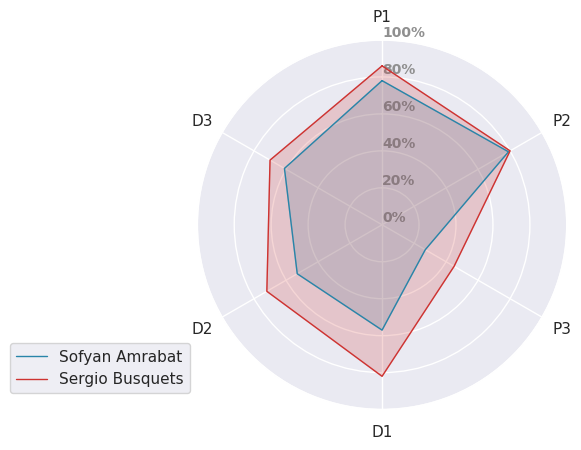

In [ ]:
radar_plot("Sofyan Amrabat")

<ipython-input-83-0928ee67284c>:40: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.2980392156862745, 0.4470588235294118, 0.6901960784313725, 1)). The keyword argument will take precedence.
  ax.fill(angles, values, 'b', alpha = 0.2, color = "#2885A9")
<ipython-input-83-0928ee67284c>:46: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(0.7686274509803922, 0.3058823529411765, 0.3215686274509804, 1)). The keyword argument will take precedence.
  ax.fill(angles, values, 'r', alpha = 0.2, color = "#CE3331")


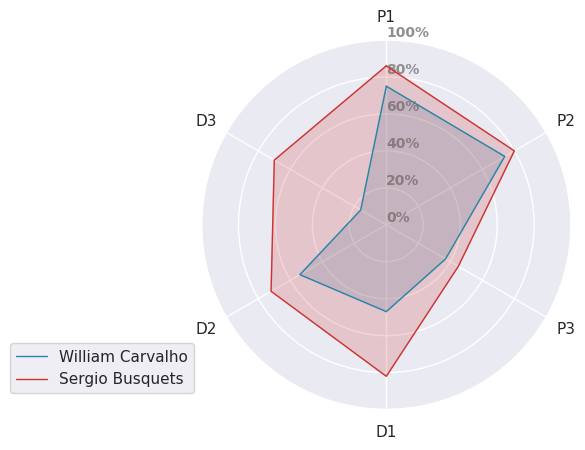

In [ ]:
radar_plot("William Carvalho")

<ipython-input-83-0928ee67284c>:40: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.2980392156862745, 0.4470588235294118, 0.6901960784313725, 1)). The keyword argument will take precedence.
  ax.fill(angles, values, 'b', alpha = 0.2, color = "#2885A9")
<ipython-input-83-0928ee67284c>:46: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(0.7686274509803922, 0.3058823529411765, 0.3215686274509804, 1)). The keyword argument will take precedence.
  ax.fill(angles, values, 'r', alpha = 0.2, color = "#CE3331")


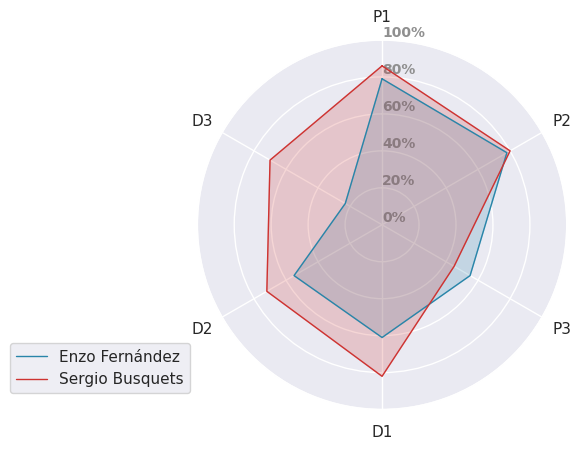

In [ ]:
radar_plot("Enzo Fernández")

<ipython-input-83-0928ee67284c>:40: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.2980392156862745, 0.4470588235294118, 0.6901960784313725, 1)). The keyword argument will take precedence.
  ax.fill(angles, values, 'b', alpha = 0.2, color = "#2885A9")
<ipython-input-83-0928ee67284c>:46: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(0.7686274509803922, 0.3058823529411765, 0.3215686274509804, 1)). The keyword argument will take precedence.
  ax.fill(angles, values, 'r', alpha = 0.2, color = "#CE3331")


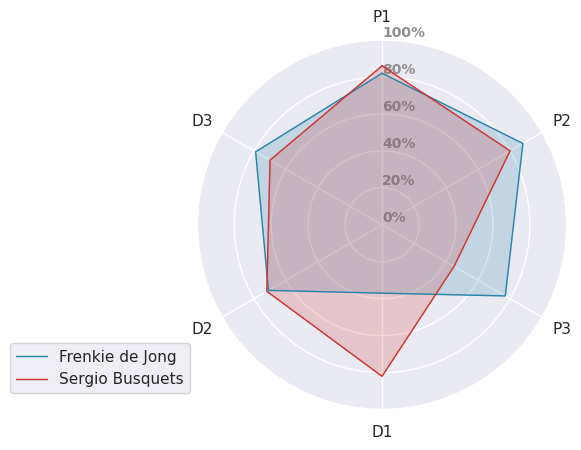

In [ ]:
radar_plot("Frenkie de Jong")

<ipython-input-83-0928ee67284c>:40: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.2980392156862745, 0.4470588235294118, 0.6901960784313725, 1)). The keyword argument will take precedence.
  ax.fill(angles, values, 'b', alpha = 0.2, color = "#2885A9")
<ipython-input-83-0928ee67284c>:46: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(0.7686274509803922, 0.3058823529411765, 0.3215686274509804, 1)). The keyword argument will take precedence.
  ax.fill(angles, values, 'r', alpha = 0.2, color = "#CE3331")


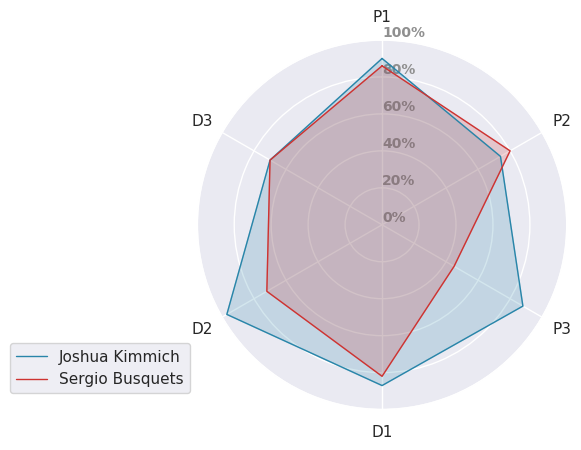

In [ ]:
radar_plot("Joshua Kimmich")

<ipython-input-83-0928ee67284c>:40: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.2980392156862745, 0.4470588235294118, 0.6901960784313725, 1)). The keyword argument will take precedence.
  ax.fill(angles, values, 'b', alpha = 0.2, color = "#2885A9")
<ipython-input-83-0928ee67284c>:46: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(0.7686274509803922, 0.3058823529411765, 0.3215686274509804, 1)). The keyword argument will take precedence.
  ax.fill(angles, values, 'r', alpha = 0.2, color = "#CE3331")


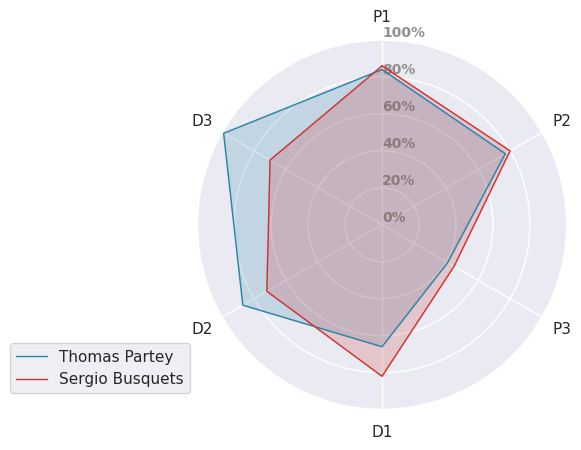

In [ ]:
radar_plot("Thomas Partey")

<ipython-input-83-0928ee67284c>:40: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.2980392156862745, 0.4470588235294118, 0.6901960784313725, 1)). The keyword argument will take precedence.
  ax.fill(angles, values, 'b', alpha = 0.2, color = "#2885A9")
<ipython-input-83-0928ee67284c>:46: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(0.7686274509803922, 0.3058823529411765, 0.3215686274509804, 1)). The keyword argument will take precedence.
  ax.fill(angles, values, 'r', alpha = 0.2, color = "#CE3331")


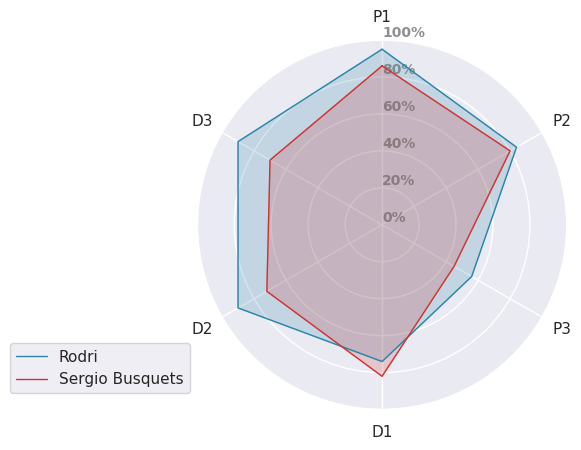

In [ ]:
radar_plot("Rodri")

<ipython-input-83-0928ee67284c>:40: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.2980392156862745, 0.4470588235294118, 0.6901960784313725, 1)). The keyword argument will take precedence.
  ax.fill(angles, values, 'b', alpha = 0.2, color = "#2885A9")
<ipython-input-83-0928ee67284c>:46: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(0.7686274509803922, 0.3058823529411765, 0.3215686274509804, 1)). The keyword argument will take precedence.
  ax.fill(angles, values, 'r', alpha = 0.2, color = "#CE3331")


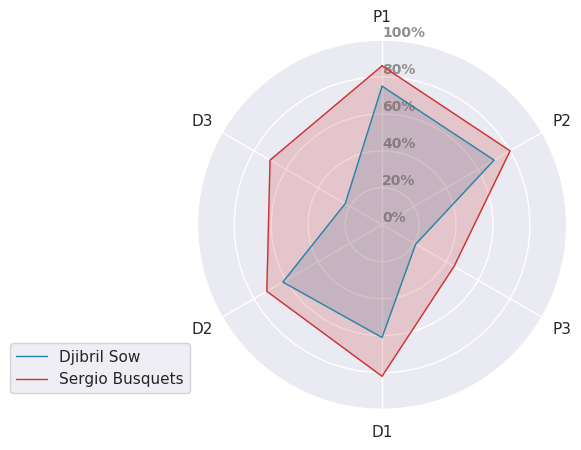

In [ ]:
radar_plot("Djibril Sow")